In [70]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
import optuna
from catboost import CatBoostClassifier
from matplotlib import pyplot as plt
import seaborn as sns

pd.set_option('future.no_silent_downcasting', True)

In [71]:
df_train = pd.read_csv('../data/model/train.csv')
df_test = pd.read_csv('../data/model/test.csv')

In [72]:
ids = df_test['PassengerId']

df_all = [df_train, df_test]
for df in df_all:
    df.drop('Name', axis = 1, inplace= True)

In [73]:
df_train.isna().sum(axis=0)

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

In [74]:
print(df_train.info())
df_train.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 823.6+ KB
None


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
count,8693,8492,8476,8494,8511,8514.000000,8490,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,NaN,NaN,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,True
freq,1,4602,5439,8,5915,NaN,8291,NaN,NaN,NaN,NaN,NaN,4378
mean,NaN,NaN,NaN,NaN,NaN,28.827930,NaN,224.687617,458.077203,173.729169,311.138778,304.854791,NaN
std,NaN,NaN,NaN,NaN,NaN,14.489021,NaN,666.717663,1611.489240,604.696458,1136.705535,1145.717189,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,38.000000,NaN,47.000000,76.000000,27.000000,59.000000,46.000000,NaN


499
267


Text(0.5, 1.0, 'Age group distribution')

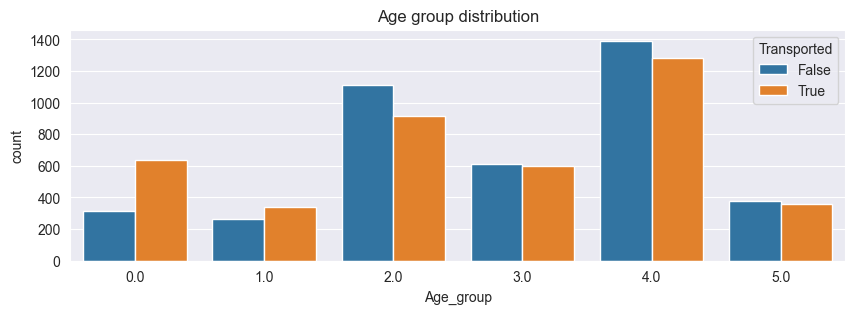

In [75]:
for dataset in df_all:
    dataset['Age_group'] = np.nan
    dataset.loc[(dataset['Age'] > 0) & (dataset['Age'] < 7), 'Age_group'] = 1
    dataset.loc[(dataset['Age'] >= 7) & (dataset['Age'] < 14), 'Age_group'] = 2
    dataset.loc[(dataset['Age'] >= 14) & (dataset['Age'] < 18), 'Age_group'] = 3
    dataset.loc[(dataset['Age'] >= 18) & (dataset['Age'] <= 25), 'Age_group'] = 4
    dataset.loc[(dataset['Age'] > 25) & (dataset['Age'] <= 30), 'Age_group'] = 5
    dataset.loc[(dataset['Age'] > 30) & (dataset['Age'] <= 50), 'Age_group'] = 6
    dataset.loc[dataset['Age'] > 50, 'Age_group'] = 7
    dataset.loc[dataset['Age'].isna(), 'Age_group'] = -1
    dataset.loc[dataset['Age'] == 0, 'Age_group'] = 0
    print(dataset['Age_group'].isna().sum(axis=0))

plt.figure(figsize=(10, 3))
sns.countplot(data=df_train, x='Age_group', hue='Transported')
plt.title('Age group distribution')

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Age_group,Expenditure,No_spending,Group,Group_size,Cabin_deck,Cabin_number,Cabin_side,Cabin_number_group
count,8693.0,8693.000000,8693.0,8693.000000,8693.000000,8693.000000,8693.00000,8693.000000,8693.000000,8693.000000,8693.000000,8693.0,8693.00000,8693.000000,8693.000000,8693.000000,8693.0,8693.000000,8693.0,8494.000000
unique,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,3.0,NaN
top,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,1.0,NaN
freq,4734.0,NaN,6072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2837.0,NaN,4343.0,NaN
mean,NaN,0.349362,NaN,28.829811,0.023007,222.846483,453.20348,171.704608,308.324253,301.799386,0.503624,5.0,1457.87821,0.413436,4633.389624,2.035546,NaN,705.640170,NaN,1.042030
std,NaN,0.476796,NaN,14.375374,0.149934,660.285467,1596.15444,597.773085,1125.463301,1134.073255,0.500016,0.0,2810.85922,0.492478,2671.028856,1.596347,NaN,1119.741774,NaN,1.269427
min,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,5.0,0.00000,0.000000,1.000000,1.000000,NaN,0.000000,NaN,0.000000
25%,NaN,0.000000,NaN,19.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,5.0,0.00000,0.000000,2319.000000,1.000000,NaN,169.000000,NaN,0.000000
50%,NaN,0.000000,NaN,27.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,5.0,724.00000,0.000000,4630.000000,1.000000,NaN,434.000000,NaN,1.000000
75%,NaN,1.000000,NaN,37.500000,0.000000,60.000000,85.00000,32.000000,74.000000,55.000000,1.000000,5.0,1449.00000,1.000000,6883.000000,3.000000,NaN,1018.000000,NaN,2.000000


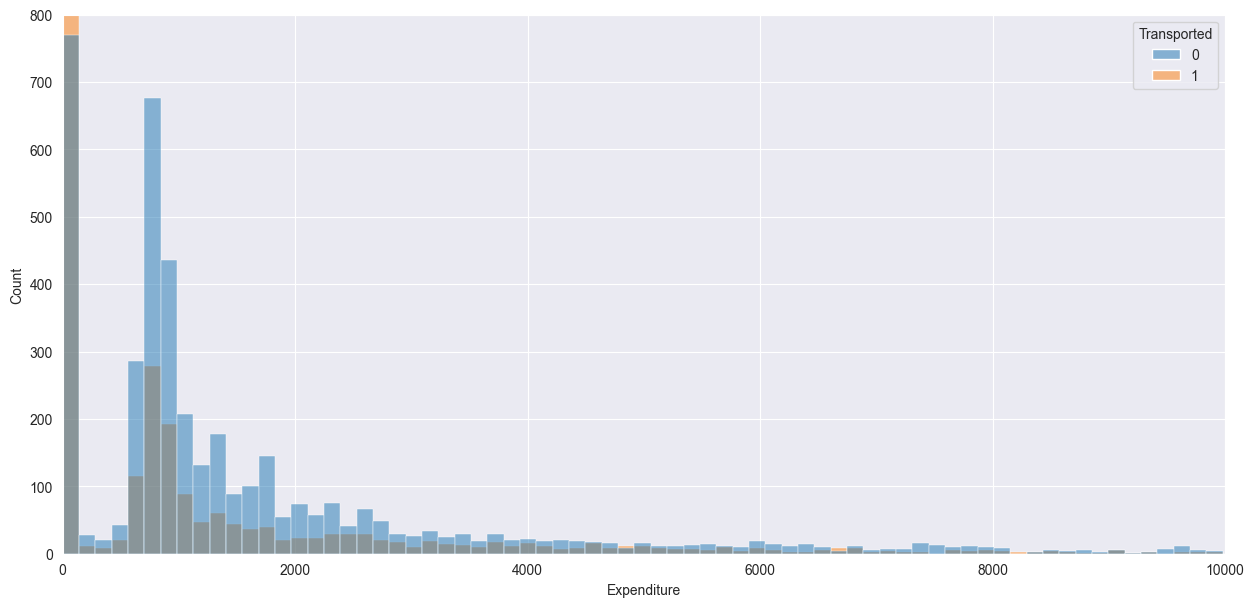

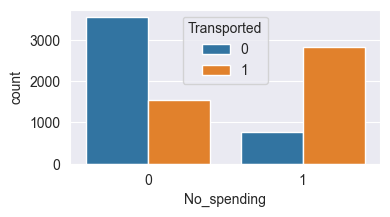

In [112]:
for dataset in df_all: 
    dataset['Expenditure']=dataset[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
    dataset['No_spending']=(dataset['Expenditure']==0).astype(int)

fig=plt.figure(figsize=(15,7))
sns.histplot(data=df_train, x='Expenditure', hue='Transported')
plt.ylim([0,800])
plt.xlim([0,10000])

fig=plt.figure(figsize=(4,2))
sns.countplot(data=df_train, x='No_spending', hue='Transported')

df_train.describe(include='all')

<Axes: xlabel='Age_group', ylabel='count'>

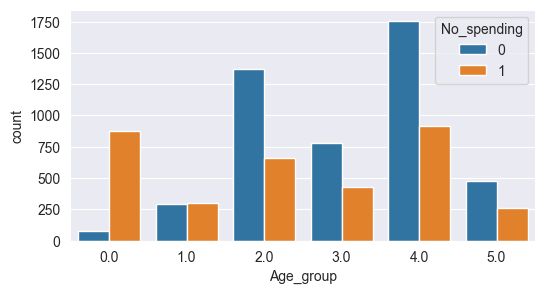

In [77]:
fig=plt.figure(figsize=(6,3))
sns.countplot(data=df_train, x='Age_group', hue='No_spending')

<Axes: xlabel='Age_group', ylabel='Expenditure'>

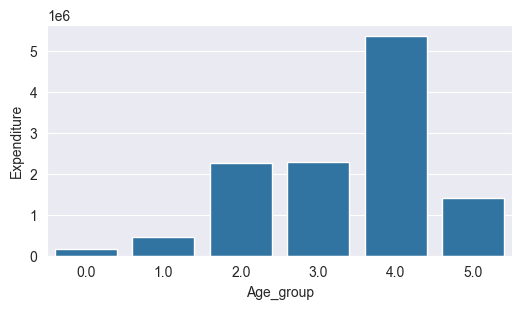

In [78]:
grouped_data = df_train.groupby('Age_group')['Expenditure'].sum().reset_index()

fig=plt.figure(figsize=(6,3))
sns.barplot(data=grouped_data, x='Age_group', y='Expenditure')

(0.0, 10000.0)

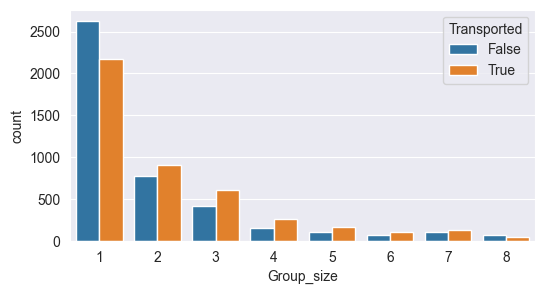

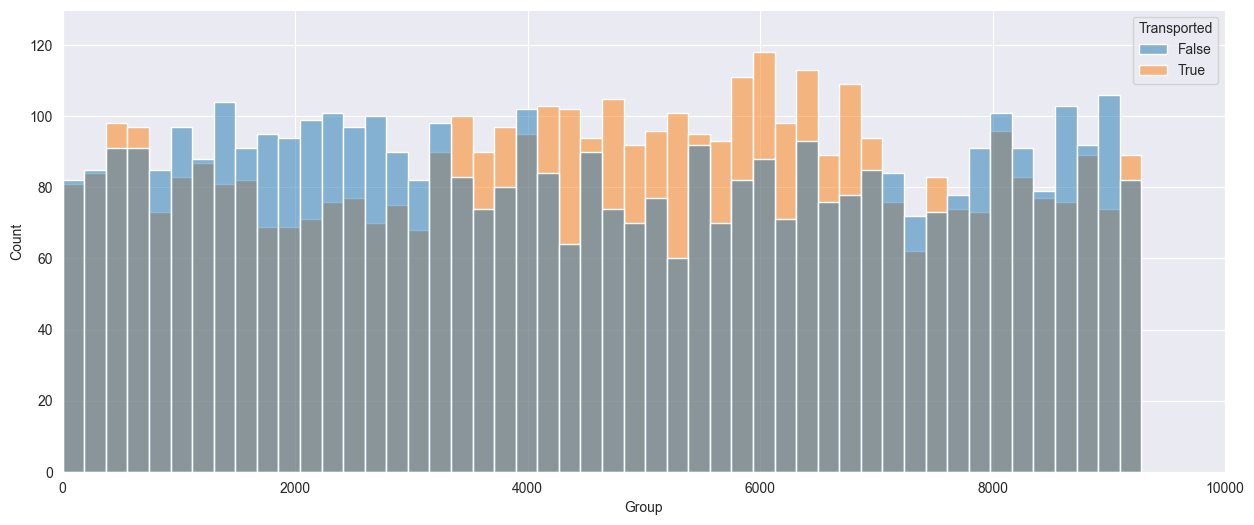

In [79]:
for dataset in df_all: 
    dataset['Group'] = dataset['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
    dataset['Group_size']=dataset['Group'].map(lambda x: dataset['Group'].value_counts()[x])
    
fig = plt.figure(figsize= (6,3))
sns.countplot(data=df_train, x='Group_size', hue='Transported')

fig = plt.figure(figsize= (15,6))
sns.histplot(data=df_train, x='Group', hue='Transported', bins=50)
plt.ylim([0,130])
plt.xlim([0,10000])

In [80]:
for dataset in df_all: 
    dataset['Cabin'] = dataset['Cabin'].fillna('Z/9999/Z')
    dataset['Cabin_deck'] = dataset['Cabin'].apply(lambda x: x.split('/')[0])
    dataset['Cabin_number'] = dataset['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
    dataset['Cabin_side'] = dataset['Cabin'].apply(lambda x: x.split('/')[2])
    
    dataset.loc[dataset['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
    dataset.loc[dataset['Cabin_number']==9999, 'Cabin_number']=np.nan
    dataset.loc[dataset['Cabin_side']=='Z', 'Cabin_side']=np.nan

    dataset.drop('Cabin', axis=1, inplace=True)

In [81]:
print(df_train.Cabin_deck.unique())
print(df_train.Cabin_number.unique())
print(df_train.Cabin_side.unique())
df_train[['Cabin_deck', 'Cabin_number', 'Cabin_side']].describe(include='all')

['B' 'F' 'A' 'G' nan 'E' 'D' 'C' 'T']
[0.000e+00 1.000e+00 2.000e+00 ... 1.892e+03 1.893e+03 1.894e+03]
['P' 'S' nan]


,Cabin_deck,Cabin_number,Cabin_side
count,8494,8494.000000,8494
unique,8,NaN,2
top,F,NaN,S
freq,2794,NaN,4288
mean,NaN,600.367671,NaN
std,NaN,511.867226,NaN
min,NaN,0.000000,NaN
25%,NaN,167.250000,NaN
50%,NaN,427.000000,NaN
75%,NaN,999.000000,NaN


<Axes: xlabel='Cabin_side', ylabel='count'>

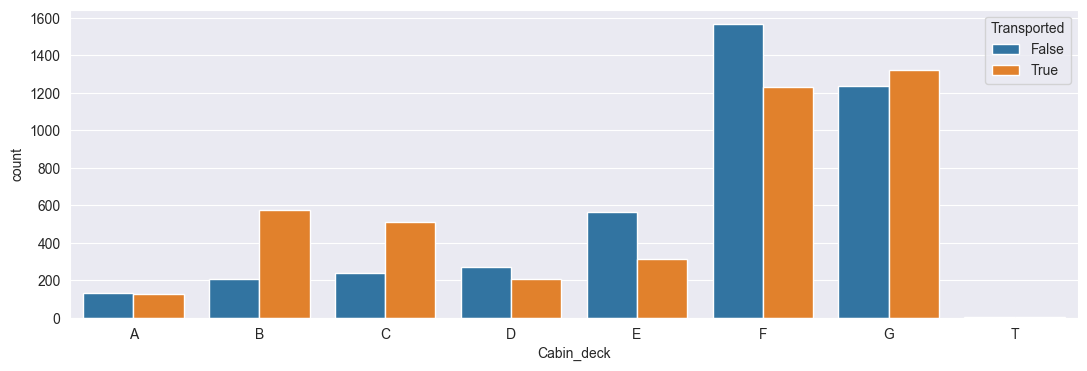

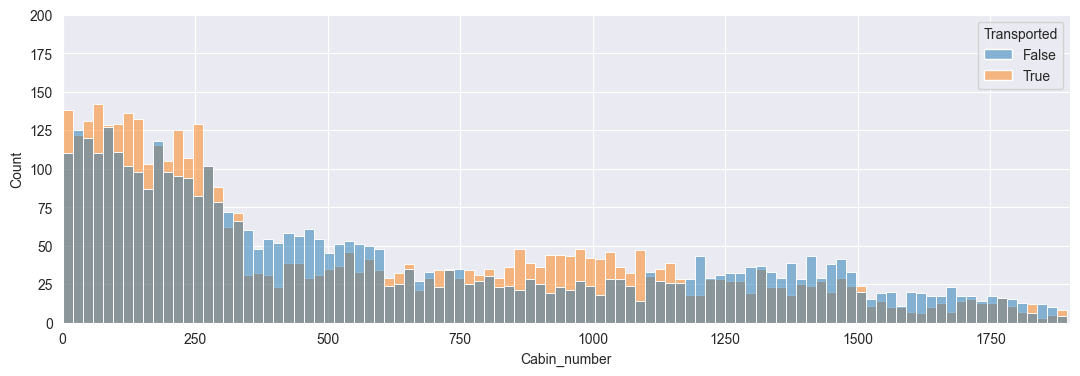

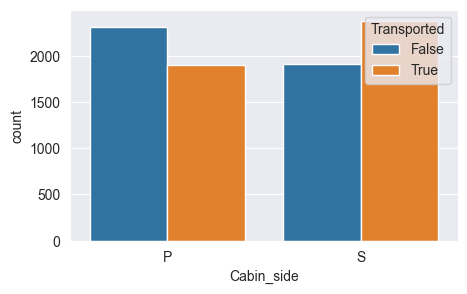

In [82]:
fig=plt.figure(figsize=(13, 4))
sns.countplot(data=df_train, x='Cabin_deck', hue='Transported', order=['A','B','C','D','E','F','G','T'])

fig=plt.figure(figsize=(13, 4))
sns.histplot(data=df_train, x='Cabin_number', hue='Transported', bins=100)
plt.xlim(0, 1900)
plt.ylim(0, 200)

fig=plt.figure(figsize=(5, 3))
sns.countplot(data=df_train, x='Cabin_side', hue='Transported')

<Axes: xlabel='Group', ylabel='Count'>

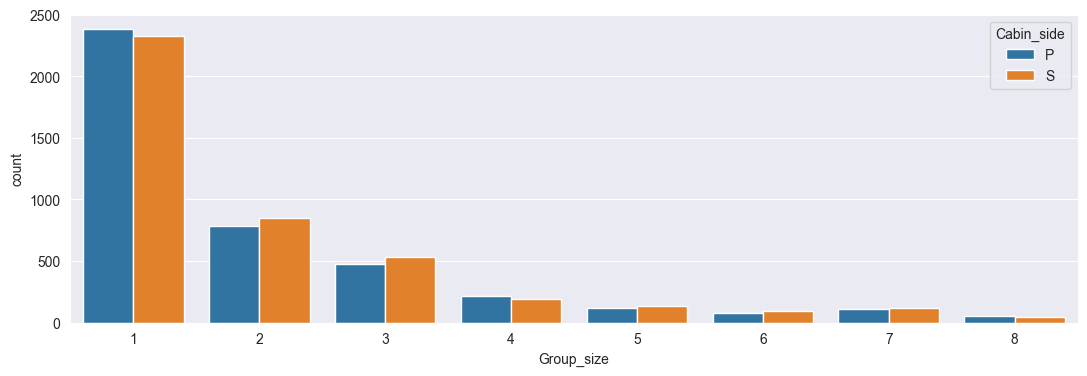

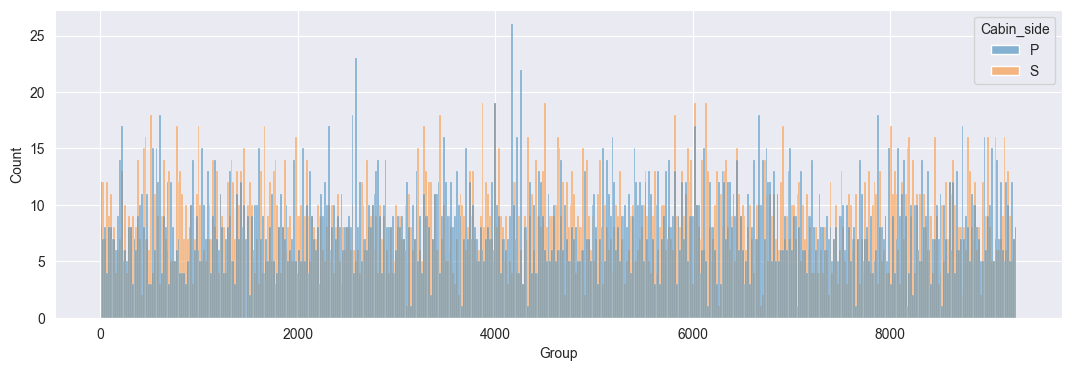

In [83]:
fig=plt.figure(figsize=(13, 4))
sns.countplot(data=df_train, x='Group_size', hue='Cabin_side')

fig=plt.figure(figsize=(13, 4))
sns.histplot(data=df_train, x='Group', hue='Cabin_side', bins=500)

<Axes: xlabel='HomePlanet', ylabel='count'>

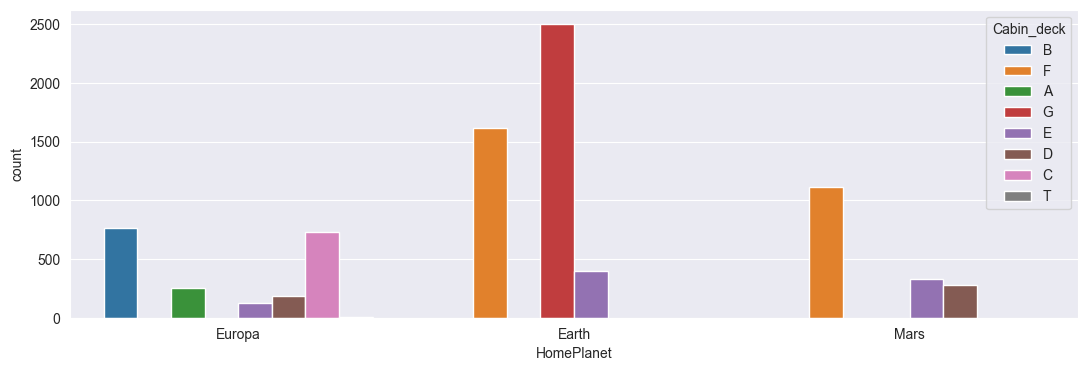

In [84]:
fig=plt.figure(figsize=(13, 4))
sns.countplot(data=df_train, x='HomePlanet', hue='Cabin_deck')

(0.0, 10.0)

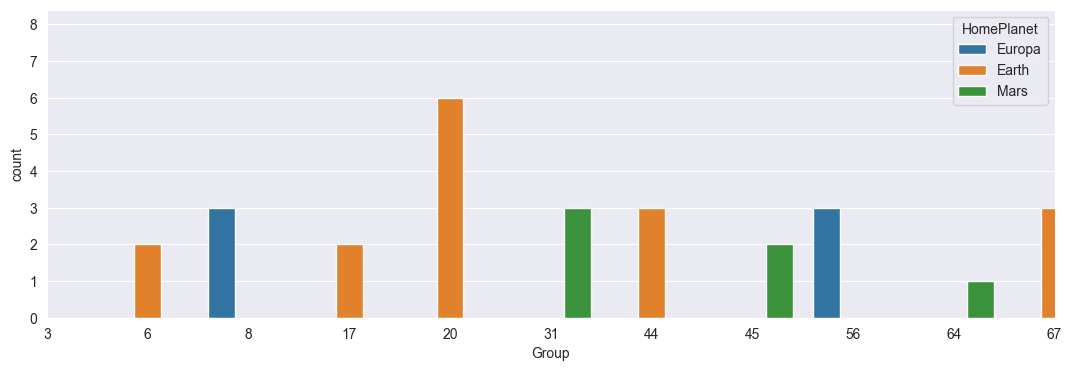

In [85]:
fig=plt.figure(figsize=(13, 4))
sns.countplot(data=df_train[df_train['Group_size'] > 1], x='Group', hue='HomePlanet')
plt.xlim(0, 10)

In [86]:
df_train['Cabin_number'].describe(include='all')

count    8494.000000
mean      600.367671
std       511.867226
min         0.000000
25%       167.250000
50%       427.000000
75%       999.000000
max      1894.000000
Name: Cabin_number, dtype: float64

<Axes: xlabel='Cabin_number_group', ylabel='count'>

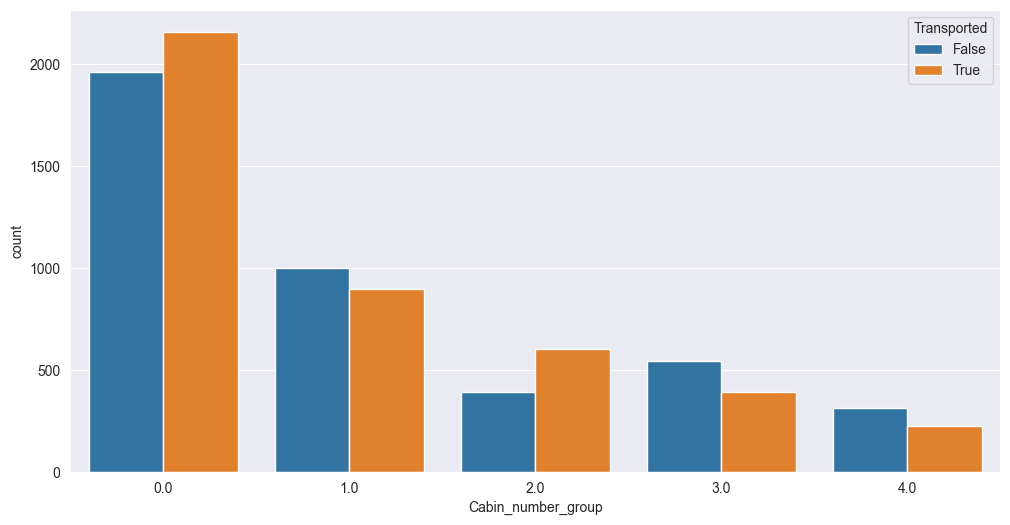

In [87]:
for dataset in df_all:
    dataset['Cabin_number_group'] = np.nan
    dataset.loc[dataset['Cabin_number'] < 400, 'Cabin_number_group'] = 0
    dataset.loc[(dataset['Cabin_number'] >= 400) & (dataset['Cabin_number'] < 900), 'Cabin_number_group'] = 1
    dataset.loc[(dataset['Cabin_number'] >= 900) & (dataset['Cabin_number'] <= 1200), 'Cabin_number_group'] = 2
    dataset.loc[(dataset['Cabin_number'] > 1200) & (dataset['Cabin_number'] <= 1500), 'Cabin_number_group'] = 3
    dataset.loc[(dataset['Cabin_number'] > 1500) & (dataset['Cabin_number'] < 9999), 'Cabin_number_group'] = 4
    dataset.loc[dataset['Cabin_number'] == 9999, 'Cabin_number_group'] = 5
    
fig = plt.figure(figsize=(12,6))
sns.countplot(data=df_train, x='Cabin_number_group', hue='Transported')

In [88]:
for df in df_all:
    print(df.isna().sum(axis=0), '\n')

PassengerId             0
HomePlanet            201
CryoSleep             217
Destination           182
Age                   179
VIP                   203
RoomService           181
FoodCourt             183
ShoppingMall          208
Spa                   183
VRDeck                188
Transported             0
Age_group             499
Expenditure             0
No_spending             0
Group                   0
Group_size              0
Cabin_deck            199
Cabin_number          199
Cabin_side            199
Cabin_number_group    199
dtype: int64 

PassengerId             0
HomePlanet             87
CryoSleep              93
Destination            92
Age                    91
VIP                    93
RoomService            82
FoodCourt             106
ShoppingMall           98
Spa                   101
VRDeck                 80
Age_group             267
Expenditure             0
No_spending             0
Group                   0
Group_size              0
Cabin_deck            1

In [89]:
for dataset in df_all:
    GHP_gb=dataset.groupby(['Group', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

    GHP_index=dataset[dataset['HomePlanet'].isna()][(dataset[dataset['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index

    dataset.loc[GHP_index,'HomePlanet']=dataset.iloc[GHP_index,:]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

    print(dataset['HomePlanet'].isna().sum())

111
46


In [90]:
for dataset in df_all:
    CH_gb=dataset.groupby(['Cabin_deck', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

    GHP_index=dataset[dataset['HomePlanet'].isna()][(dataset[dataset['HomePlanet'].isna()]['Cabin_deck']).isin(CH_gb.index)].index

    dataset.loc[GHP_index,'HomePlanet']=dataset.iloc[GHP_index,:]['Cabin_deck'].map(lambda x: CH_gb.idxmax(axis=1)[x])

    print(dataset['HomePlanet'].isna().sum())
print(df_train[df_train['HomePlanet'].isna()].head())

4
1
     PassengerId HomePlanet CryoSleep  Destination   Age    VIP  RoomService  \
1550     1645_01        NaN      True  55 Cancri e  18.0  False          0.0   
1714     1823_01        NaN     False  TRAPPIST-1e  67.0  False        143.0   
3858     4134_01        NaN      True  TRAPPIST-1e  40.0  False          0.0   
7293     7801_01        NaN     False  55 Cancri e  21.0  False       1720.0   

      FoodCourt  ShoppingMall    Spa  ...  Transported  Age_group  \
1550        0.0           0.0    0.0  ...        False        NaN   
1714       68.0         496.0  182.0  ...         True        5.0   
3858        0.0           0.0    0.0  ...         True        4.0   
7293     2337.0           0.0    1.0  ...        False        2.0   

      Expenditure  No_spending  Group  Group_size  Cabin_deck Cabin_number  \
1550          0.0            1   1645           1         NaN          NaN   
1714        898.0            0   1823           1         NaN          NaN   
3858          0

In [91]:
def replace_mean(table, column):
    val = table[column].mean()
    table[column] = table[column].fillna(val)


def replace_mode(table, column):
    val = table[column].mode()[0]
    table[column] = table[column].fillna(val)
    
for dataset in df_all:
    replace_mode(dataset, 'HomePlanet')
    print(dataset['HomePlanet'].isna().sum())

0
0


<Axes: xlabel='CryoSleep', ylabel='count'>

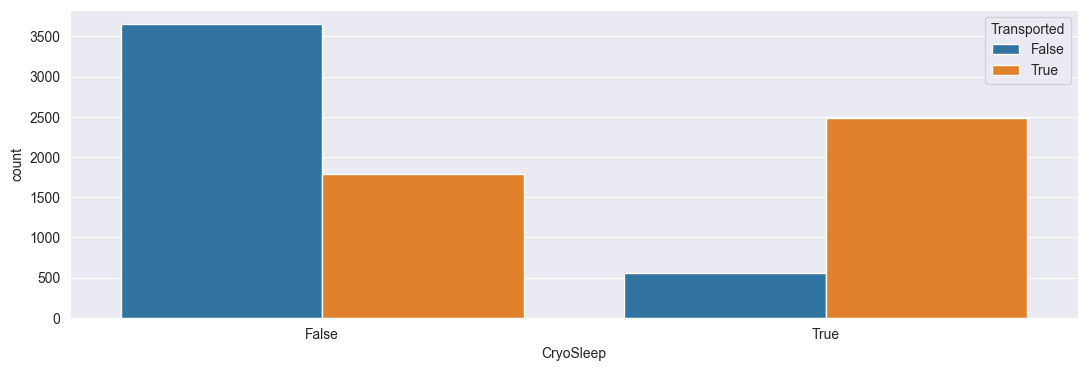

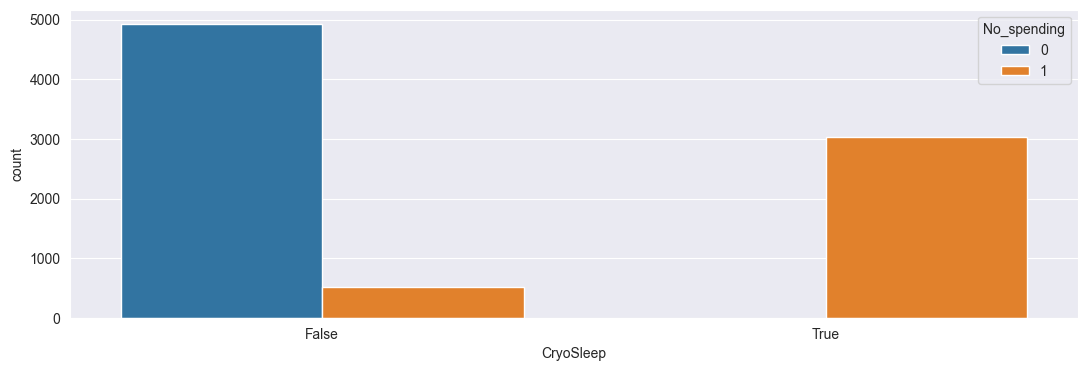

In [92]:
fig=plt.figure(figsize=(13, 4))
sns.countplot(data=df_train, x='CryoSleep', hue='Transported')

fig=plt.figure(figsize=(13, 4))
sns.countplot(data=df_train, x='CryoSleep', hue='No_spending')

In [93]:
for dataset in df_all:
    dataset.loc[dataset['CryoSleep'] == True, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = 0
    dataset.loc[dataset['CryoSleep'].isna() & dataset['No_spending'] == True, 'CryoSleep'] = 0
    dataset.loc[dataset['CryoSleep'].isna(), 'CryoSleep'] = False
    print(dataset['CryoSleep'].isna().sum())

0
0


In [94]:
for dataset in df_all:
    GD_gb=dataset.groupby(['Group', 'Destination'])['Destination'].size().unstack().fillna(0)

    GHP_index=dataset[dataset['Destination'].isna()][(dataset[dataset['Destination'].isna()]['Group']).isin(GD_gb.index)].index

    dataset.loc[GHP_index,'Destination']=dataset.iloc[GHP_index,:]['Group'].map(lambda x: GD_gb.idxmax(axis=1)[x])

    print(dataset['Destination'].isna().sum())
print('\n')

for dataset in df_all:
    GD_gb=dataset.groupby(['Cabin_deck', 'Destination'])['Destination'].size().unstack().fillna(0)

    GHP_index=dataset[dataset['Destination'].isna()][(dataset[dataset['Destination'].isna()]['Cabin_deck']).isin(GD_gb.index)].index

    dataset.loc[GHP_index,'Destination']=dataset.iloc[GHP_index,:]['Cabin_deck'].map(lambda x: GD_gb.idxmax(axis=1)[x])

    print(dataset['Destination'].isna().sum())
print('\n')

for dataset in df_all:
    replace_mode(dataset, 'Destination')
    print(dataset['Destination'].isna().sum())

103
51


2
0


0
0


In [95]:
df_train.isna().sum(axis = 0)

PassengerId             0
HomePlanet              0
CryoSleep               0
Destination             0
Age                   179
VIP                   203
RoomService           113
FoodCourt             113
ShoppingMall          112
Spa                   118
VRDeck                126
Transported             0
Age_group             499
Expenditure             0
No_spending             0
Group                   0
Group_size              0
Cabin_deck            199
Cabin_number          199
Cabin_side            199
Cabin_number_group    199
dtype: int64

In [96]:
for data in df_all:
    GCD_gb=data[data['Group_size']>1].groupby(['Group','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)
    GCN_gb=data[data['Group_size']>1].groupby(['Group','Cabin_number'])['Cabin_number'].size().unstack().fillna(0)
    GCS_gb=data[data['Group_size']>1].groupby(['Group','Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

    GCS_index=data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Group']).isin(GCS_gb.index)].index
    data.loc[GCS_index,'Cabin_side']=data.iloc[GCS_index,:]['Group'].map(lambda x: GCS_gb.idxmax(axis=1)[x])
    
    data['Cabin_side'] = data['Cabin_side'].fillna('Z')
    print(data['Cabin_side'].isna().sum(axis=0))
    
    GCN_index=data[data['Cabin_number'].isna()][(data[data['Cabin_number'].isna()]['Group']).isin(GCN_gb.index)].index
    data.loc[GCN_index,'Cabin_number']=data.iloc[GCN_index,:]['Group'].map(lambda x: GCN_gb.idxmax(axis=1)[x])
    
    GCD_index=data[data['Cabin_deck'].isna()][(data[data['Cabin_deck'].isna()]['Group']).isin(GCD_gb.index)].index
    data.loc[GCD_index,'Cabin_deck']=data.iloc[GCD_index,:]['Group'].map(lambda x: GCD_gb.idxmax(axis=1)[x])
    
    na_rows_CD=data.loc[data['Cabin_deck'].isna() & data['Group_size'] == 1,'Cabin_deck'].index
    data.loc[data['Cabin_deck'].isna(),'Cabin_deck']=data[data['Group_size'] == 1].groupby(['HomePlanet','Destination',])['Cabin_deck'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CD]
    
    data['Cabin_deck'] = data['Cabin_deck'].fillna('F')
    print(data['Cabin_deck'].isna().sum(axis=0))
    
    data['Cabin_number'] = data['Cabin_number'].fillna(9999)
    print(data['Cabin_number'].isna().sum(axis=0))

0
0
0
0
0
0


In [97]:
for data in df_all:
    data.groupby(['HomePlanet','No_spending','Group_size','Cabin_deck', 'Cabin_side'])['Age'].mean().unstack().fillna(0)

    na_rows_A=data.loc[data['Age'].isna(),'Age'].index
    data.loc[data['Age'].isna(),'Age']=data.groupby(['HomePlanet','No_spending','Group_size','Cabin_deck', 'Cabin_side'])['Age'].transform(lambda x: x.fillna(x.mean()))[na_rows_A]
    print(data['Age'].isna().sum(axis=0))

0
0


In [98]:
for data in df_all:
    data.loc[data['Age']<14,'Age_group']=0
    data.loc[(data['Age']>=14) & (data['Age']<18),'Age_group']=1
    data.loc[(data['Age']>= 18) & (data['Age']<=25),'Age_group']=2
    data.loc[(data['Age']>25) & (data['Age']<=30),'Age_group']=3
    data.loc[(data['Age']>30) & (data['Age']<=50),'Age_group']=4
    data.loc[data['Age']>50,'Age_group']=5
df_train['Age_group'].isna().sum(axis=0)

0

In [99]:
for data in df_all:
    data.groupby(['HomePlanet','Group_size','Age_group'])['Expenditure'].mean().unstack().fillna(0)

    for col in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
        na_rows=data.loc[data[col].isna(),col].index
        data.loc[data[col].isna(),col]=data.groupby(['HomePlanet','Group_size','Age_group'])[col].transform(lambda x: x.fillna(x.mean()))[na_rows]

In [100]:
for data in df_all:
    mode_fill = data.groupby(['HomePlanet','Group_size','Age_group', 'Destination', 'Expenditure'])['VIP'].transform(lambda x: x.mode().iat[0] if not x.mode().empty else False)
    data['VIP'] = data['VIP'].fillna(mode_fill)

In [101]:
df_train["Transported"] = df_train["Transported"].astype(int)

for df in df_all:
    df["VIP"] = df["VIP"].astype(int)
    df["CryoSleep"] = df["CryoSleep"].astype(int)
    df = df.drop('PassengerId', axis = 1, inplace=True)

for col in df_train.columns:
    if df_train[col].dtype == 'object':
        print(col)

HomePlanet
Destination
Cabin_deck
Cabin_side


In [102]:
df_train.HomePlanet.unique()

array(['Europa', 'Earth', 'Mars'], dtype=object)

In [103]:
df_train['HomePlanet'] = df_train['HomePlanet'].replace({'Earth': 0, 'Europa': 1, 'Mars': 2})
df_test['HomePlanet'] = df_test['HomePlanet'].replace({'Earth': 0, 'Europa': 1, 'Mars': 2})

In [104]:
df_train.Destination.unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e'], dtype=object)

In [105]:
df_train['Destination'] = df_train['Destination'].replace({'TRAPPIST-1e': 0, 'PSO J318.5-22': 1, '55 Cancri e': 2})
df_test['Destination'] = df_test['Destination'].replace({'TRAPPIST-1e': 0, 'PSO J318.5-22': 1, '55 Cancri e': 2})

df_train.head(50)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Age_group,Expenditure,No_spending,Group,Group_size,Cabin_deck,Cabin_number,Cabin_side,Cabin_number_group
0,1,0,0,39.0,0,0.000000,0.0,0.000000,0.000000,0.0,0,5,0.0,1,1,1,B,0.0,P,0.0
1,0,0,0,24.0,0,109.000000,9.0,25.000000,549.000000,44.0,1,5,736.0,0,2,1,F,0.0,S,0.0
2,1,0,0,58.0,1,43.000000,3576.0,0.000000,6715.000000,49.0,0,5,10383.0,0,3,2,A,0.0,S,0.0
3,1,0,0,33.0,0,0.000000,1283.0,371.000000,3329.000000,193.0,0,5,5176.0,0,3,2,A,0.0,S,0.0
4,0,0,0,16.0,0,303.000000,70.0,151.000000,565.000000,2.0,1,5,1091.0,0,4,1,F,1.0,S,0.0
5,0,0,1,44.0,0,0.000000,483.0,0.000000,291.000000,0.0,1,5,774.0,0,5,1,F,0.0,P,0.0
6,0,0,0,26.0,0,42.000000,1539.0,3.000000,0.000000,0.0,1,5,1584.0,0,6,2,F,2.0,S,0.0
7,0,1,0,28.0,0,0.000000,0.0,0.000000,0.000000,0.0,1,5,0.0,1,6,2,G,0.0,S,0.0
8,0,0,0,35.0,0,0.000000,785.0,17.000000,216.000000,0.0,1,5,1018.0,0,7,1,F,3.0,S,0.0
9,1,1,2,14.0,0,0.000000,0.0,0.000000,0.000000,0.0,1,5,0.0,1,8,3,B,1.0,P,0.0


In [106]:
df_train['Cabin_deck'].unique()

array(['B', 'F', 'A', 'G', 'E', 'D', 'C', 'T'], dtype=object)

In [107]:
df_train['Cabin_side'].unique()

array(['P', 'S', 'Z'], dtype=object)

In [108]:
for df in df_all:
    df['Cabin_deck'] = df['Cabin_deck'].replace({'B': 1, 'F': 5, 'A': 0, 'G': 6, 'E': 4, 'D': 3, 'C': 2, 'T': 7})
    df['Cabin_side'] = df['Cabin_side'].replace({'P': 0, 'S': 1, 'Z': -1})

In [109]:
target = 'Transported'

y = df_train[target].values
X = df_train.drop(columns=target).values

In [110]:
def kfold(X, y, k=5):
    X_trains = []
    y_trains = []
    X_vals = []
    y_vals = []

    for i in range(k):
        low = int(len(y) * i / k)
        high = int(len(y) * (i + 1) / k)
        y_vals.append(y[low:high])
        X_vals.append(X[low:high, :])

    for i in range(k):
        y_temp = []
        X_temp = []
        for j in range(k):
            if j != i:
                y_temp.append(y_vals[j])
                X_temp.append(X_vals[j])

        y_trains.append(np.concatenate(y_temp))
        X_trains.append(np.vstack(X_temp))
    result = []
    for i in range(k):
        result.append(((X_trains[i], y_trains[i]), (X_vals[i], y_vals[i])))
    return result

In [111]:
model = GradientBoostingClassifier()
accs = []
for ((X_train, y_train), (X_val, y_val)) in kfold(X, y, 15):
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    accs.append(np.mean(pred == y_val))
acc_mean = np.mean(accs)
acc_mean

ValueError: Input X contains NaN.
GradientBoostingClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
for df in df_all:
    df = df.drop('Group', axis=1, inplace=True)

In [ ]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 5, 10),
        'iterations': trial.suggest_int('iterations', 100, 1200),
        # 'cat_features': [0, 1, 2, 3, 5, 11]
    }

    k_fold = trial.suggest_int('k_fold', 7, 15)

    model = CatBoostClassifier(**params)

    accs = []
    for ((X_train, y_train), (X_val, y_val)) in kfold(X, y, k_fold):
        model.fit(X_train, y_train)
        pred = model.predict(X_val)
        accs.append(np.mean(pred == y_val))
    acc_mean = np.mean(accs)

    return acc_mean

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("Best params:", best_params)

In [ ]:
model = CatBoostClassifier(learning_rate=0.061996690102900195, depth=6, iterations=588)

accs = []
for ((X_train, y_train), (X_val, y_val)) in kfold(X, y, 12):
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    accs.append(np.mean(pred == y_val))
acc_mean = np.mean(accs)

print(acc_mean)

In [ ]:
predict = model.predict(df_test)
predict = np.where(predict == 1, True, False)

predictions_df = pd.DataFrame({'PassengerId': ids, 'Transported': predict})

predictions_df.to_csv('predictions.csv', index=False)